In [3]:
!pip install -r requirements.txt
!pip install scipy

In [4]:
apikey = "tJl01ofHyVljUR9Zpj444bDQ07REEpVXRdx1kpRl"

In [5]:
from scipy.optimize import linprog as lp
import numpy as np
import warnings

def solve_subsistence_problem(FoodNutrients,Prices,diet_min,diet_max,max_weight=None,tol=1e-6):
    """Solve Stigler's Subsistence Cost Problem.

    Inputs:
       - FoodNutrients : A pd.DataFrame with rows corresponding to foods, columns to nutrients.
       - Prices : A pd.Series of prices for different foods
       - diet_min : A pd.Series of DRIs, with index corresponding to columns of FoodNutrients,
                    describing minimum intakes.
       - diet_max : A pd.Series of DRIs, with index corresponding to columns of FoodNutrients,
                    describing maximum intakes.
       - max_weight : Maximum weight (in hectograms) allowed for diet.
       - tol : Solution values smaller than this in absolute value treated as zeros.
       
    """
    p = Prices.apply(lambda x:x.magnitude).dropna()

    # Compile list that we have both prices and nutritional info for; drop if either missing
    use = p.index.intersection(FoodNutrients.columns)
    p = p[use]

    # Drop nutritional information for foods we don't know the price of,
    # and replace missing nutrients with zeros.
    Aall = FoodNutrients[p.index].fillna(0)

    # Drop rows of A that we don't have constraints for.
    Amin = Aall.loc[Aall.index.intersection(diet_min.index)]

    Amax = Aall.loc[Aall.index.intersection(diet_max.index)]

    # Minimum requirements involve multiplying constraint by -1 to make <=.
    A = pd.concat([Amin,
                   -Amax])

    b = pd.concat([diet_min,
                   -diet_max]) # Note sign change for max constraints

    # Make sure order of p, A, b are consistent
    A = A.reindex(p.index,axis=1)
    A = A.reindex(b.index,axis=0)

    if max_weight is not None:
        # Add up weights of foods consumed
        A.loc['Hectograms'] = -1
        b.loc['Hectograms'] = -max_weight
        
    # Now solve problem!  (Note that the linear program solver we'll use assumes
    # "less-than-or-equal" constraints.  We can switch back and forth by
    # multiplying $A$ and $b$ by $-1$.)

    result = lp(p, -A, -b, method='interior-point')

    result.A = A
    result.b = b
    
    if result.success:
        result.diet = pd.Series(result.x,index=p.index)
    else: # No feasible solution?
        warnings.warn(result.message)
        result.diet = pd.Series(result.x,index=p.index)*np.nan  

    return result

In [6]:
SHEETs = [("https://docs.google.com/spreadsheets/d/17XCCM7-_Vk2erOKQmZsOZ2fYSsPUGzbGyTYZd_02bVk/edit#gid=0","Berkeley Bowl")]
SHEETs2 = [("https://docs.google.com/spreadsheets/d/17XCCM7-_Vk2erOKQmZsOZ2fYSsPUGzbGyTYZd_02bVk/edit#gid=0","Safeway")]
SHEETs3 = [("https://docs.google.com/spreadsheets/d/17XCCM7-_Vk2erOKQmZsOZ2fYSsPUGzbGyTYZd_02bVk/edit#gid=0","Whole Foods")]
SHEETs4 = [("https://docs.google.com/spreadsheets/d/17XCCM7-_Vk2erOKQmZsOZ2fYSsPUGzbGyTYZd_02bVk/edit#gid=0","Trader Joe's")]

In [7]:
import pandas as pd
from eep153_tools.sheets import read_sheets

df_bb = read_sheets(SHEETs[0][0])[SHEETs[0][1]]
df_sw = read_sheets(SHEETs2[0][0])[SHEETs2[0][1]]
df_wf = read_sheets(SHEETs3[0][0])[SHEETs3[0][1]]
df_tj = read_sheets(SHEETs4[0][0])[SHEETs4[0][1]]

Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.


In [8]:
# do NOT continuously run next cell

In [9]:
##do not rerun this cell while making changes to other cells, just run once. It takes like 5 minutes to run
import fooddatacentral as fdc
import warnings

D = {}
count = 0
for food in  df_bb.Food.tolist():
    try:
        FDC = df_bb.loc[df_bb.Food==food,:].FDC[count]
        count+=1
        D[food] = fdc.nutrients(apikey,FDC).Quantity
    except AttributeError: 
        warnings.warn("Couldn't find FDC Code %s for food %s." % (food,FDC))        

FoodNutrients = pd.DataFrame(D,dtype=float)

In [10]:
def change_df_col_to_int(df, col):
   # df[col] = df[col].fillna(1)
    df[col] = df[col].str.replace('$', '')
    df[col] = df[col].astype(float)
    return df

In [11]:
change_df_col_to_int(df_bb, 'Price')
change_df_col_to_int(df_sw, 'Price')
change_df_col_to_int(df_wf, 'Price')
change_df_col_to_int(df_tj, 'Price')

/tmp/ipykernel_183/2300178093.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace('$', '')


,Food Group,Food,Quantity,Units,Price,Date,Location,Brand Name,FDC,Vegan (1/0),Vegetarian (1/0),Pescetarian (1/0)
0,Protein,Chicken breast,1.0000,lbs,6.99,02/27/22,Trader Joes,Trader Joes,2092152,0,0,0
1,Protein,Chicken thigh,1.0000,lbs,4.49,02/27/22,Trader Joes,Trader Joes,1899680,0,0,0
2,Protein,Ground Beef,1.0000,lbs,6.99,02/27/22,Trader Joes,Trader Joes,1597053,0,0,0
3,Protein,Eggs,672.0000,g,2.69,02/27/22,Trader Joes,Trader Joes,577532,0,1,1
4,Protein,Peanut Butter,16.0000,oz,1.99,02/27/22,Trader Joes,Trader Joes,1100559,1,1,1
5,Protein,Chickpeas,15.5000,oz,0.79,02/27/22,Trader Joes,Trader Joes,1100433,1,1,1
6,Protein,Tofu,14.0000,oz,1.79,02/27/22,Trader Joes,Trader Joes,1864416,1,1,1
7,Protein,Pork Loin,1.0000,lbs,7.99,02/27/22,Trader Joes,Trader Joes,168314,0,0,0
8,Protein,Ground Pork,16.0000,oz,5.99,02/27/22,Trader Joes,Trader Joes,1887701,0,0,0
9,Protein,Ground Turkey,16.0000,oz,3.49,02/27/22,Trader Joes,Trader Joes,1626048,0,0,0


In [12]:
# Convert food quantities to FDC units
def find_unit_prices(df):
    df['FDC Quantity'] = df[['Quantity','Units']].T.apply(lambda x : fdc.units(x['Quantity'],x['Units']))

# Now may want to filter df by time or place--need to get a unique set of food names.
    df['FDC Price'] = df['Price']/df['FDC Quantity']

    df.dropna(how='any') # Drop food with any missing data

# To use minimum price observed
    Prices = df.groupby('Food',sort=False)['FDC Price'].min()
    return Prices

In [13]:
prices_bb = find_unit_prices(df_bb)
prices_sw = find_unit_prices(df_sw)
prices_wf = find_unit_prices(df_wf)
prices_tj = find_unit_prices(df_tj)

/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


In [14]:
from eep153_tools.sheets import read_sheets

DRI_url = "https://docs.google.com/spreadsheets/d/1y95IsQ4HKspPW3HHDtH7QMtlDA66IUsCHJLutVL-MMc/"

DRIs = read_sheets(DRI_url)

# Define *minimums*
diet_min = DRIs['diet_minimums'].set_index('Nutrition')

# Define *maximums*
diet_max = DRIs['diet_maximums'].set_index('Nutrition')

Key available for students@eep153.iam.gserviceaccount.com.


In [15]:
group = 'M 19-30'
tol = 1e-6

result = solve_subsistence_problem(FoodNutrients,prices_bb,diet_min[group],diet_max[group],tol=tol)

print("Cost of diet at Berkeley Bowl for %s is $%4.2f per day.\n" % (group,result.fun))

# Put back into nice series
diet = result.diet

print("\nDiet (in 100s of grams or milliliters):")
print(diet[diet >= tol])  # Drop items with quantities less than precision of calculation.
print()

tab = pd.DataFrame({"Outcome":np.abs(result.A).dot(diet),"Recommendation":np.abs(result.b)})
print("\nWith the following nutritional outcomes of interest:")
print(tab)
print()

print("\nConstraining nutrients are:")
excess = tab.diff(axis=1).iloc[:,1]
print(excess.loc[np.abs(excess) < tol*100].index.tolist())

Cost of diet at Berkeley Bowl for M 19-30 is $5.90 per day.


Diet (in 100s of grams or milliliters):
Peanut Butter     1.252638
Black Beans       0.727011
Sliced Turkey     0.154066
Cheddar cheese    1.682770
Bananas           3.103032
Jalepenos         6.646954
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          2778.581602          2400.0
Protein                           96.088183            56.0
Fiber, total dietary              44.420969            33.6
Folate, DFE                      400.000001           400.0
Calcium, Ca                     1451.566640          1000.0
Carbohydrate, by difference      191.411712           130.0
Iron, Fe                           8.155628             8.0
Magnesium, Mg                    444.160246           400.0
Niacin                            29.030873            16.0
Phosph

In [16]:
group = 'F 19-30'
tol = 1e-6

result = solve_subsistence_problem(FoodNutrients,prices_bb,diet_min[group],diet_max[group],tol=tol)

print("Cost of diet at Berkeley Bowl for %s is $%4.2f per day.\n" % (group,result.fun))

# Put back into nice series
diet = result.diet

print("\nDiet (in 100s of grams or milliliters):")
print(diet[diet >= tol])  # Drop items with quantities less than precision of calculation.
print()

tab = pd.DataFrame({"Outcome":np.abs(result.A).dot(diet),"Recommendation":np.abs(result.b)})
print("\nWith the following nutritional outcomes of interest:")
print(tab)
print()

print("\nConstraining nutrients are:")
excess = tab.diff(axis=1).iloc[:,1]
print(excess.loc[np.abs(excess) < tol*100].index.tolist())

Cost of diet at Berkeley Bowl for F 19-30 is $5.58 per day.


Diet (in 100s of grams or milliliters):
Peanut Butter     1.323929
Black Beans       1.153673
Pinto Beans       1.069741
Sliced Turkey     0.397261
Cheddar cheese    0.765054
Cauliflower       0.021551
Jalepenos         8.485981
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          2760.029553          2000.0
Protein                          109.459821            46.0
Fiber, total dietary              90.552010            28.0
Folate, DFE                      400.000001           400.0
Calcium, Ca                     1000.000010          1000.0
Carbohydrate, by difference      224.581427           130.0
Iron, Fe                          18.000000            18.0
Magnesium, Mg                    381.150386           310.0
Niacin                            32.93

In [17]:
# Get df_bb in terms of diet restrictions
def diet_df(df, col):
    return df[df[col] == 1]

# Creating vegan, vegetarian, and pescetarian dfs for bb
vegan_df_bb = diet_df(df_bb, 'Vegan (1/0)')
veg_df_bb = diet_df(df_bb, 'Vegetarian (1/0)')
pesc_df_bb = diet_df(df_bb, 'Pescetarian (1/0)')

In [18]:
# find prices for diet restricted dfs
vegan_prices_bb = find_unit_prices(vegan_df_bb)
veg_prices_bb = find_unit_prices(veg_df_bb)
pesc_prices_bb = find_unit_prices(pesc_df_bb)

/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
/tmp/ipykernel_183/3294993695.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FDC Quantity'] = df[['Quantity','Units']].T.apply(lambda x : fdc.units(x['Quantity'],x['Units']))
/tmp/ipykernel_183/3294993695.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FDC Price'] = df['Price']/df['FDC Quantity']


In [19]:
# find minimum cost meal with diet restrictions using solve_subsistence_problem()

def diet_restricted_subsistence(prices, type, sex, store):
    group = sex+' 19-30'
    tol = 1e-6

    result = solve_subsistence_problem(FoodNutrients,prices,diet_min[group],diet_max[group],tol=tol)

    print("Cost of a "+type+" diet at "+store+" for %s is $%4.2f per day.\n" % (group,result.fun))

    # Put back into nice series
    diet = result.diet

    print("\nDiet (in 100s of grams or milliliters):")
    print(diet[diet >= tol])  # Drop items with quantities less than precision of calculation.
    print()

    tab = pd.DataFrame({"Outcome":np.abs(result.A).dot(diet),"Recommendation":np.abs(result.b)})
    print("\nWith the following nutritional outcomes of interest:")
    print(tab)
    print()

    print("\nConstraining nutrients are:")
    excess = tab.diff(axis=1).iloc[:,1]
    print(excess.loc[np.abs(excess) < tol*100].index.tolist())

In [20]:
vegan_bb_m = diet_restricted_subsistence(vegan_prices_bb, 'vegan', 'M', 'Berkeley Bowl')

Cost of a vegan diet at Berkeley Bowl for M 19-30 is $6.60 per day.


Diet (in 100s of grams or milliliters):
Black Beans        0.305245
Oat Milk           4.800000
Wheat Cereal       3.251026
Bananas            0.000002
Romaine Lettuce    1.269001
Jalepenos          7.971659
Salt               0.000005
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          2430.104469          2400.0
Protein                           59.565165            56.0
Fiber, total dietary              72.976476            33.6
Folate, DFE                      400.000008           400.0
Calcium, Ca                     1068.965863          1000.0
Carbohydrate, by difference      366.870986           130.0
Iron, Fe                          13.231337             8.0
Magnesium, Mg                    565.207413           400.0
Niacin                  

In [21]:
vegan_bb_f = diet_restricted_subsistence(vegan_prices_bb, 'vegan', 'F', 'Berkeley Bowl')

Cost of a vegan diet at Berkeley Bowl for F 19-30 is $6.21 per day.


Diet (in 100s of grams or milliliters):
Black Beans         0.202889
Pinto Beans         1.044150
Oat Milk            4.800000
Wheat Cereal        2.258862
Romaine Lettuce     0.305253
Jalepenos          10.871412
Salt                0.000004
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          2558.884273          2000.0
Protein                           67.375705            46.0
Fiber, total dietary             106.530046            28.0
Folate, DFE                      400.000007           400.0
Calcium, Ca                     1114.494844          1000.0
Carbohydrate, by difference      360.929115           130.0
Iron, Fe                          18.000000            18.0
Magnesium, Mg                    465.209288           310.0
Niacin           

In [22]:
veg_bb_m = diet_restricted_subsistence(veg_prices_bb, 'vegetarian', 'M', 'Berkeley Bowl')

Cost of a vegetarian diet at Berkeley Bowl for M 19-30 is $6.44 per day.


Diet (in 100s of grams or milliliters):
Black Beans        0.379955
Cheddar cheese     0.432985
Oat Milk           3.882072
Wheat Cereal       2.687290
Romaine Lettuce    0.704403
Jalepenos          9.306437
Salt               0.000002
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          2542.786189          2400.0
Protein                           64.123192            56.0
Fiber, total dietary              69.443098            33.6
Folate, DFE                      400.000003           400.0
Calcium, Ca                     1214.788054          1000.0
Carbohydrate, by difference      328.244391           130.0
Iron, Fe                          11.901004             8.0
Magnesium, Mg                    515.166708           400.0
Niacin             

In [23]:
veg_bb_f = diet_restricted_subsistence(veg_prices_bb, 'vegetarian', 'F', 'Berkeley Bowl')

Cost of a vegetarian diet at Berkeley Bowl for F 19-30 is $6.21 per day.


Diet (in 100s of grams or milliliters):
Black Beans         0.202889
Pinto Beans         1.044150
Oat Milk            4.800000
Wheat Cereal        2.258862
Romaine Lettuce     0.305253
Jalepenos          10.871412
Salt                0.000010
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          2558.884419          2000.0
Protein                           67.375706            46.0
Fiber, total dietary             106.530045            28.0
Folate, DFE                      400.000015           400.0
Calcium, Ca                     1114.494872          1000.0
Carbohydrate, by difference      360.929115           130.0
Iron, Fe                          18.000000            18.0
Magnesium, Mg                    465.209285           310.0
Niacin      

In [24]:
pesc_bb_m = diet_restricted_subsistence(pesc_prices_bb, 'pescetarian', 'M', 'Berkeley Bowl')

Cost of a pescetarian diet at Berkeley Bowl for M 19-30 is $6.44 per day.


Diet (in 100s of grams or milliliters):
Black Beans        0.379955
Cheddar cheese     0.432985
Oat Milk           3.882072
Wheat Cereal       2.687290
Romaine Lettuce    0.704403
Jalepenos          9.306438
Salt               0.000010
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          2542.786343          2400.0
Protein                           64.123191            56.0
Fiber, total dietary              69.443098            33.6
Folate, DFE                      400.000029           400.0
Calcium, Ca                     1214.788088          1000.0
Carbohydrate, by difference      328.244387           130.0
Iron, Fe                          11.901003             8.0
Magnesium, Mg                    515.166715           400.0
Niacin            

In [25]:
pesc_bb_f = diet_restricted_subsistence(pesc_prices_bb, 'pescetarian', 'F', 'Berkeley Bowl')

Cost of a pescetarian diet at Berkeley Bowl for F 19-30 is $6.21 per day.


Diet (in 100s of grams or milliliters):
Black Beans         0.202889
Pinto Beans         1.044150
Oat Milk            4.800000
Wheat Cereal        2.258861
Romaine Lettuce     0.305253
Jalepenos          10.871412
Salt                0.000012
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          2558.884592          2000.0
Protein                           67.375708            46.0
Fiber, total dietary             106.530043            28.0
Folate, DFE                      400.000020           400.0
Calcium, Ca                     1114.494897          1000.0
Carbohydrate, by difference      360.929113           130.0
Iron, Fe                          18.000000            18.0
Magnesium, Mg                    465.209278           310.0
Niacin     

In [26]:
group = 'M 19-30'
tol = 1e-6

result = solve_subsistence_problem(FoodNutrients,prices_sw,diet_min[group],diet_max[group],tol=tol)

print("Cost of diet at Safeway for %s is $%4.2f per day.\n" % (group,result.fun))

# Put back into nice series
diet = result.diet

print("\nDiet (in 100s of grams or milliliters):")
print(diet[diet >= tol])  # Drop items with quantities less than precision of calculation.
print()

tab = pd.DataFrame({"Outcome":np.abs(result.A).dot(diet),"Recommendation":np.abs(result.b)})
print("\nWith the following nutritional outcomes of interest:")
print(tab)
print()

print("\nConstraining nutrients are:")
excess = tab.diff(axis=1).iloc[:,1]
print(excess.loc[np.abs(excess) < tol*100].index.tolist())

Cost of diet at Safeway for M 19-30 is $4.17 per day.


Diet (in 100s of grams or milliliters):
Peanut Butter      3.607849
Chickpeas          0.000002
Black Beans        0.003748
Pinto Beans        0.173419
Sliced Turkey      0.214842
Tuna               0.522255
Almond Milk        2.944323
Oat Milk           0.908684
Potatoes           4.090345
Romaine Lettuce    1.690839
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          2699.303608          2400.0
Protein                          114.112526            56.0
Fiber, total dietary              33.600003            33.6
Folate, DFE                      400.000008           400.0
Calcium, Ca                     1000.000068          1000.0
Carbohydrate, by difference      178.874700           130.0
Iron, Fe                          13.719934             8.0
Magnesium, Mg 

In [27]:
group = 'F 19-30'
tol = 1e-6

result = solve_subsistence_problem(FoodNutrients,prices_sw,diet_min[group],diet_max[group],tol=tol)

print("Cost of diet at Safeway for %s is $%4.2f per day.\n" % (group,result.fun))

# Put back into nice series
diet = result.diet

print("\nDiet (in 100s of grams or milliliters):")
print(diet[diet >= tol])  # Drop items with quantities less than precision of calculation.
print()

tab = pd.DataFrame({"Outcome":np.abs(result.A).dot(diet),"Recommendation":np.abs(result.b)})
print("\nWith the following nutritional outcomes of interest:")
print(tab)
print()

print("\nConstraining nutrients are:")
excess = tab.diff(axis=1).iloc[:,1]
print(excess.loc[np.abs(excess) < tol*100].index.tolist())

Cost of diet at Safeway for F 19-30 is $3.87 per day.


Diet (in 100s of grams or milliliters):
Peanut Butter      2.307612
Black Beans        0.943213
Pinto Beans        0.474155
Sliced Turkey      0.542168
Almond Milk        2.436239
Oat Milk           0.462652
Potatoes           2.193451
Romaine Lettuce    3.812955
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          2160.119582          2000.0
Protein                          103.408963            46.0
Fiber, total dietary              53.999672            28.0
Folate, DFE                      400.000000           400.0
Calcium, Ca                     1000.000000          1000.0
Carbohydrate, by difference      196.477615           130.0
Iron, Fe                          18.000000            18.0
Magnesium, Mg                    501.737338           310.0
Niacin    

In [28]:
# Creating vegan, vegetarian, and pescetarian dfs for sw
vegan_df_sw = diet_df(df_sw, 'Vegan (1/0)')
veg_df_sw = diet_df(df_sw, 'Vegetarian (1/0)')
pesc_df_sw = diet_df(df_sw, 'Pescetarian (1/0)')
# find prices for diet restricted dfs
vegan_prices_sw = find_unit_prices(vegan_df_sw)
veg_prices_sw = find_unit_prices(veg_df_sw)
pesc_prices_sw = find_unit_prices(pesc_df_sw)

/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
/tmp/ipykernel_183/3294993695.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FDC Quantity'] = df[['Quantity','Units']].T.apply(lambda x : fdc.units(x['Quantity'],x['Units']))
/tmp/ipykernel_183/3294993695.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FDC Price'] = df['Price']/df['FDC Quantity']


In [29]:
vegan_sw_m = diet_restricted_subsistence(vegan_prices_sw, 'vegan', 'M', 'Safeway')

Cost of a vegan diet at Safeway for M 19-30 is $5.00 per day.


Diet (in 100s of grams or milliliters):
Peanut Butter      1.425898
Black Beans        0.267523
Oat Milk           4.800000
Wheat Cereal       1.985236
Potatoes           1.786192
Romaine Lettuce    6.249055
Vegetable Oil      0.385848
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          2400.000000          2400.0
Protein                           79.277227            56.0
Fiber, total dietary              50.179294            33.6
Folate, DFE                      443.471235           400.0
Calcium, Ca                     1170.183274          1000.0
Carbohydrate, by difference      288.723142           130.0
Iron, Fe                          15.897285             8.0
Magnesium, Mg                    612.844706           400.0
Niacin                        

In [30]:
vegan_sw_f = diet_restricted_subsistence(vegan_prices_sw, 'vegan', 'F', 'Safeway')

Cost of a vegan diet at Safeway for F 19-30 is $4.63 per day.


Diet (in 100s of grams or milliliters):
Peanut Butter      1.408386
Black Beans        0.741499
Pinto Beans        0.257980
Oat Milk           4.800000
Wheat Cereal       1.175406
Romaine Lettuce    8.152173
Vegetable Oil      0.120797
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          2000.000007          2000.0
Protein                           84.256249            46.0
Fiber, total dietary              57.598384            28.0
Folate, DFE                      480.270783           400.0
Calcium, Ca                     1259.766999          1000.0
Carbohydrate, by difference      242.327366           130.0
Iron, Fe                          18.000000            18.0
Magnesium, Mg                    499.148983           310.0
Niacin                        

In [31]:
veg_sw_m = diet_restricted_subsistence(veg_prices_sw, 'vegetarian', 'M', 'Safeway')

Cost of a vegetarian diet at Safeway for M 19-30 is $5.00 per day.


Diet (in 100s of grams or milliliters):
Peanut Butter      1.425898
Black Beans        0.267523
Oat Milk           4.800000
Wheat Cereal       1.985236
Potatoes           1.786192
Romaine Lettuce    6.249055
Vegetable Oil      0.385848
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          2400.000000          2400.0
Protein                           79.277227            56.0
Fiber, total dietary              50.179294            33.6
Folate, DFE                      443.471236           400.0
Calcium, Ca                     1170.183274          1000.0
Carbohydrate, by difference      288.723142           130.0
Iron, Fe                          15.897285             8.0
Magnesium, Mg                    612.844706           400.0
Niacin                   

In [32]:
veg_sw_f = diet_restricted_subsistence(veg_prices_sw, 'vegetarian', 'F', 'Safeway')

Cost of a vegetarian diet at Safeway for F 19-30 is $4.63 per day.


Diet (in 100s of grams or milliliters):
Peanut Butter      1.408387
Chickpeas          0.000001
Black Beans        0.741621
Pinto Beans        0.257914
Almond Milk        0.000003
2% milk            0.000002
Oat Milk           4.800000
Wheat Cereal       1.175412
Brown Rice         0.000001
Potatoes           0.000008
Romaine Lettuce    8.152144
Vegetable Oil      0.120749
Salt               0.000031
Sugar              0.000008
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          2000.000456          2000.0
Protein                           84.257857            46.0
Fiber, total dietary              57.597817            28.0
Folate, DFE                      480.270224           400.0
Calcium, Ca                     1259.776779          1000.0
Carbohydr

In [33]:
pesc_sw_m = diet_restricted_subsistence(pesc_prices_sw, 'pescetarian', 'M', 'Safeway')

Cost of a pescetarian diet at Safeway for M 19-30 is $4.75 per day.


Diet (in 100s of grams or milliliters):
Chicken thigh        0.000001
Eggs                 0.000002
Peanut Butter        2.523436
Chickpeas            0.000009
Tofu                 0.000002
Black Beans          0.207883
Pinto Beans          0.000007
Lentils              0.000005
Tuna                 1.153833
Almond Milk          2.874458
2% milk              0.000025
Cheddar cheese       0.000002
Unsalted butter      0.000001
Greek yogurt         0.000002
Oat Milk             0.000062
Wheat Cereal         0.828870
Granola              0.000001
Brown Rice           0.000006
Jasmine Rice         0.000003
Potatoes             1.483150
Bananas              0.000006
Apples               0.000003
Avocados             0.000002
Tomatoes             0.000001
Kale                 0.000002
Red Onion            0.000002
Yellow Onion         0.000006
Cauliflower          0.000002
Broccoli             0.000005
Carrots             

In [34]:
pesc_sw_f = diet_restricted_subsistence(pesc_prices_sw, 'pescetarian', 'F', 'Safeway')

Cost of a pescetarian diet at Safeway for F 19-30 is $4.30 per day.


Diet (in 100s of grams or milliliters):
Peanut Butter      1.329986
Black Beans        1.265065
Tuna               1.153846
Almond Milk        2.347686
Wheat Cereal       0.887338
Potatoes           0.312217
Romaine Lettuce    7.534526
Vegetable Oil      0.215326
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          2000.000000          2000.0
Protein                          108.928655            46.0
Fiber, total dietary              48.202975            28.0
Folate, DFE                      442.614359           400.0
Calcium, Ca                     1000.000000          1000.0
Carbohydrate, by difference      208.615017           130.0
Iron, Fe                          18.000000            18.0
Magnesium, Mg                    499.311272           31

In [35]:
group = 'M 19-30'
tol = 1e-6

result = solve_subsistence_problem(FoodNutrients,prices_wf,diet_min[group],diet_max[group],tol=tol)

print("Cost of diet at Whole Foods for %s is $%4.2f per day.\n" % (group,result.fun))

# Put back into nice series
diet = result.diet

print("\nDiet (in 100s of grams or milliliters):")
print(diet[diet >= tol])  # Drop items with quantities less than precision of calculation.
print()

tab = pd.DataFrame({"Outcome":np.abs(result.A).dot(diet),"Recommendation":np.abs(result.b)})
print("\nWith the following nutritional outcomes of interest:")
print(tab)
print()

print("\nConstraining nutrients are:")
excess = tab.diff(axis=1).iloc[:,1]
print(excess.loc[np.abs(excess) < tol*100].index.tolist())

Cost of diet at Whole Foods for M 19-30 is $5.65 per day.


Diet (in 100s of grams or milliliters):
Peanut Butter     1.658280
Chickpeas         0.648133
Black Beans       0.012525
Sliced Turkey     0.318226
Almond Milk       5.928579
Cheddar cheese    1.063297
Bananas           8.068819
Broccoli          0.158821
Spinach           0.195205
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          2400.000007          2400.0
Protein                           85.410140            56.0
Fiber, total dietary              36.286390            33.6
Folate, DFE                      400.000000           400.0
Calcium, Ca                     2043.341393          1000.0
Carbohydrate, by difference      250.108059           130.0
Iron, Fe                           9.324228             8.0
Magnesium, Mg                    602.208403    

In [36]:
group = 'F 19-30'
tol = 1e-6

result = solve_subsistence_problem(FoodNutrients,prices_wf,diet_min[group],diet_max[group],tol=tol)

print("Cost of diet at Whole Foods for %s is $%4.2f per day.\n" % (group,result.fun))

# Put back into nice series
diet = result.diet

print("\nDiet (in 100s of grams or milliliters):")
print(diet[diet >= tol])  # Drop items with quantities less than precision of calculation.
print()

tab = pd.DataFrame({"Outcome":np.abs(result.A).dot(diet),"Recommendation":np.abs(result.b)})
print("\nWith the following nutritional outcomes of interest:")
print(tab)
print()

print("\nConstraining nutrients are:")
excess = tab.diff(axis=1).iloc[:,1]
print(excess.loc[np.abs(excess) < tol*100].index.tolist())

Cost of diet at Whole Foods for F 19-30 is $4.84 per day.


Diet (in 100s of grams or milliliters):
Peanut Butter    0.954956
Chickpeas        2.749680
Black Beans      0.217461
Pinto Beans      0.601510
Sliced Turkey    0.552867
Almond Milk      7.445309
Oat Milk         0.377060
Bananas          6.870437
Broccoli         0.122949
Spinach          0.131567
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          2000.000149          2000.0
Protein                           82.066739            46.0
Fiber, total dietary              72.410243            28.0
Folate, DFE                      400.000008           400.0
Calcium, Ca                     1803.427953          1000.0
Carbohydrate, by difference      306.052219           130.0
Iron, Fe                          18.000001            18.0
Magnesium, Mg                 

In [37]:
# Creating vegan, vegetarian, and pescetarian dfs for wf
vegan_df_wf = diet_df(df_wf, 'Vegan (1/0)')
veg_df_wf = diet_df(df_wf, 'Vegetarian (1/0)')
pesc_df_wf = diet_df(df_wf, 'Pescetarian (1/0)')
# find prices for diet restricted dfs
vegan_prices_wf = find_unit_prices(vegan_df_wf)
veg_prices_wf = find_unit_prices(veg_df_wf)
pesc_prices_wf = find_unit_prices(pesc_df_wf)

/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
/tmp/ipykernel_183/3294993695.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FDC Quantity'] = df[['Quantity','Units']].T.apply(lambda x : fdc.units(x['Quantity'],x['Units']))
/tmp/ipykernel_183/3294993695.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FDC Price'] = df['Price']/df['FDC Quantity']


In [38]:
vegan_sw_m = diet_restricted_subsistence(vegan_prices_wf, 'vegan', 'M', 'Whole Foods')

Cost of a vegan diet at Whole Foods for M 19-30 is $6.80 per day.


Diet (in 100s of grams or milliliters):
Chickpeas       3.009007
Almond Milk     9.604722
Oat Milk        4.800000
Wheat Cereal    2.896846
Bananas         6.351040
Broccoli        0.338836
Spinach         0.139007
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          2400.000001          2400.0
Protein                           76.235950            56.0
Fiber, total dietary              81.374880            33.6
Folate, DFE                      400.000000           400.0
Calcium, Ca                     2869.153603          1000.0
Carbohydrate, by difference      492.217813           130.0
Iron, Fe                          19.074999             8.0
Magnesium, Mg                    754.010937           400.0
Niacin                            22.965367    

In [39]:
vegan_sw_f = diet_restricted_subsistence(vegan_prices_wf, 'vegan', 'F', 'Whole Foods')

Cost of a vegan diet at Whole Foods for F 19-30 is $6.15 per day.


Diet (in 100s of grams or milliliters):
Chickpeas       3.432067
Almond Milk     7.391906
Oat Milk        4.800000
Wheat Cereal    2.639425
Bananas         3.096977
Avocados        0.670678
Broccoli        0.447699
Spinach         0.025827
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          2158.703775          2000.0
Protein                           73.670203            46.0
Fiber, total dietary              76.873031            28.0
Folate, DFE                      400.000000           400.0
Calcium, Ca                     2457.549494          1000.0
Carbohydrate, by difference      409.898155           130.0
Iron, Fe                          18.000000            18.0
Magnesium, Mg                    659.668326           310.0
Niacin                

In [40]:
veg_sw_m = diet_restricted_subsistence(veg_prices_wf, 'vegetarian', 'M', 'Whole Foods')

Cost of a vegetarian diet at Whole Foods for M 19-30 is $6.80 per day.


Diet (in 100s of grams or milliliters):
Peanut Butter    0.000007
Chickpeas        3.008835
Almond Milk      9.604720
Oat Milk         4.799999
Wheat Cereal     2.896852
Bananas          6.351134
Avocados         0.000063
Kale             0.000002
Broccoli         0.338821
Spinach          0.139005
Cucumbers        0.000003
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          2400.001222          2400.0
Protein                           76.235024            56.0
Fiber, total dietary              81.374401            33.6
Folate, DFE                      400.000046           400.0
Calcium, Ca                     2869.145349          1000.0
Carbohydrate, by difference      492.217376           130.0
Iron, Fe                          19.074731        

In [41]:
veg_sw_f = diet_restricted_subsistence(veg_prices_wf, 'vegetarian', 'F', 'Whole Foods')

Cost of a vegetarian diet at Whole Foods for F 19-30 is $6.15 per day.


Diet (in 100s of grams or milliliters):
Chickpeas       3.432067
Almond Milk     7.391906
Oat Milk        4.800000
Wheat Cereal    2.639425
Bananas         3.096977
Avocados        0.670678
Broccoli        0.447699
Spinach         0.025827
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          2158.703777          2000.0
Protein                           73.670203            46.0
Fiber, total dietary              76.873032            28.0
Folate, DFE                      400.000000           400.0
Calcium, Ca                     2457.549496          1000.0
Carbohydrate, by difference      409.898156           130.0
Iron, Fe                          18.000000            18.0
Magnesium, Mg                    659.668327           310.0
Niacin           

In [42]:
pesc_sw_m = diet_restricted_subsistence(pesc_prices_wf, 'pescetarian', 'M', 'Whole Foods')

Cost of a pescetarian diet at Whole Foods for M 19-30 is $6.80 per day.


Diet (in 100s of grams or milliliters):
Chickpeas       3.009007
Almond Milk     9.604722
Oat Milk        4.800000
Wheat Cereal    2.896846
Bananas         6.351042
Broccoli        0.338836
Spinach         0.139007
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          2400.000050          2400.0
Protein                           76.235946            56.0
Fiber, total dietary              81.374879            33.6
Folate, DFE                      400.000001           400.0
Calcium, Ca                     2869.153557          1000.0
Carbohydrate, by difference      492.217831           130.0
Iron, Fe                          19.074998             8.0
Magnesium, Mg                    754.010942           400.0
Niacin                            22.9653

In [43]:
pesc_sw_f = diet_restricted_subsistence(pesc_prices_wf, 'pescetarian', 'F', 'Whole Foods')

Cost of a pescetarian diet at Whole Foods for F 19-30 is $6.15 per day.


Diet (in 100s of grams or milliliters):
Chickpeas       3.432067
Almond Milk     7.391906
Oat Milk        4.800000
Wheat Cereal    2.639425
Bananas         3.096977
Avocados        0.670678
Broccoli        0.447699
Spinach         0.025827
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          2158.703776          2000.0
Protein                           73.670203            46.0
Fiber, total dietary              76.873032            28.0
Folate, DFE                      400.000000           400.0
Calcium, Ca                     2457.549494          1000.0
Carbohydrate, by difference      409.898156           130.0
Iron, Fe                          18.000000            18.0
Magnesium, Mg                    659.668326           310.0
Niacin          

In [44]:
group = 'M 19-30'
tol = 1e-6

result = solve_subsistence_problem(FoodNutrients,prices_tj,diet_min[group],diet_max[group],tol=tol)

print("Cost of diet at Trader Joe's for %s is $%4.2f per day.\n" % (group,result.fun))

# Put back into nice series
diet = result.diet

print("\nDiet (in 100s of grams or milliliters):")
print(diet[diet >= tol])  # Drop items with quantities less than precision of calculation.
print()

tab = pd.DataFrame({"Outcome":np.abs(result.A).dot(diet),"Recommendation":np.abs(result.b)})
print("\nWith the following nutritional outcomes of interest:")
print(tab)
print()

print("\nConstraining nutrients are:")
excess = tab.diff(axis=1).iloc[:,1]
print(excess.loc[np.abs(excess) < tol*100].index.tolist())

Cost of diet at Trader Joe's for M 19-30 is $4.50 per day.


Diet (in 100s of grams or milliliters):
Peanut Butter      1.873266
Chickpeas          1.129695
Black Beans        1.605966
Sliced Turkey      0.240180
Cheddar cheese     1.051570
Oat Milk           0.649234
Cauliflower        1.570837
Romaine Lettuce    1.528228
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          2400.000072          2400.0
Protein                          122.582203            56.0
Fiber, total dietary              48.685268            33.6
Folate, DFE                      400.000001           400.0
Calcium, Ca                     1313.393832          1000.0
Carbohydrate, by difference      185.833265           130.0
Iron, Fe                          14.777537             8.0
Magnesium, Mg                    444.764233           400.0
Niaci

In [45]:
group = 'F 19-30'
tol = 1e-6

result = solve_subsistence_problem(FoodNutrients,prices_tj,diet_min[group],diet_max[group],tol=tol)

print("Cost of diet at Trader Joe's for %s is $%4.2f per day.\n" % (group,result.fun))

# Put back into nice series
diet = result.diet

print("\nDiet (in 100s of grams or milliliters):")
print(diet[diet >= tol])  # Drop items with quantities less than precision of calculation.
print()

tab = pd.DataFrame({"Outcome":np.abs(result.A).dot(diet),"Recommendation":np.abs(result.b)})
print("\nWith the following nutritional outcomes of interest:")
print(tab)
print()

print("\nConstraining nutrients are:")
excess = tab.diff(axis=1).iloc[:,1]
print(excess.loc[np.abs(excess) < tol*100].index.tolist())

Cost of diet at Trader Joe's for F 19-30 is $3.99 per day.


Diet (in 100s of grams or milliliters):
Peanut Butter      1.311644
Chickpeas          2.907576
Black Beans        1.636532
Sliced Turkey      0.373079
Almond Milk        0.942324
Cheddar cheese     0.012023
Oat Milk           1.789882
Cauliflower        1.231554
Romaine Lettuce    1.636693
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          2000.000001          2000.0
Protein                          104.641631            46.0
Fiber, total dietary              60.163615            28.0
Folate, DFE                      400.000000           400.0
Calcium, Ca                     1000.000011          1000.0
Carbohydrate, by difference      220.619218           130.0
Iron, Fe                          18.000000            18.0
Magnesium, Mg                    406.

In [46]:
# Creating vegan, vegetarian, and pescetarian dfs for tj
vegan_df_tj = diet_df(df_tj, 'Vegan (1/0)')
veg_df_tj = diet_df(df_tj, 'Vegetarian (1/0)')
pesc_df_tj = diet_df(df_tj, 'Pescetarian (1/0)')
# find prices for diet restricted dfs
vegan_prices_tj = find_unit_prices(vegan_df_tj)
veg_prices_tj = find_unit_prices(veg_df_tj)
pesc_prices_tj = find_unit_prices(pesc_df_tj)

/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
/tmp/ipykernel_183/3294993695.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FDC Quantity'] = df[['Quantity','Units']].T.apply(lambda x : fdc.units(x['Quantity'],x['Units']))
/tmp/ipykernel_183/3294993695.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FDC Price'] = df['Price']/df['FDC Quantity']


In [47]:
vegan_tj_m = diet_restricted_subsistence(vegan_prices_tj, 'vegan', 'M', "Trader Joe's")

Cost of a vegan diet at Trader Joe's for M 19-30 is $5.94 per day.


Diet (in 100s of grams or milliliters):
Peanut Butter      1.541385
Black Beans        0.782246
Oat Milk           4.800000
Wheat Cereal       2.620602
Cauliflower        1.402938
Romaine Lettuce    2.432432
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          2400.000005          2400.0
Protein                           94.809941            56.0
Fiber, total dietary              62.139863            33.6
Folate, DFE                      415.024351           400.0
Calcium, Ca                     1150.519841          1000.0
Carbohydrate, by difference      338.461063           130.0
Iron, Fe                          15.831849             8.0
Magnesium, Mg                    659.079325           400.0
Niacin                            37.716461          

In [48]:
vegan_tj_f = diet_restricted_subsistence(vegan_prices_tj, 'vegan', 'F', "Trader Joe's")

Cost of a vegan diet at Trader Joe's for F 19-30 is $5.43 per day.


Diet (in 100s of grams or milliliters):
Peanut Butter      1.439477
Chickpeas          2.208076
Black Beans        0.714480
Oat Milk           4.800000
Wheat Cereal       2.097341
Cauliflower        1.188025
Romaine Lettuce    1.879956
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          2444.769708          2000.0
Protein                          101.837460            46.0
Fiber, total dietary              69.055697            28.0
Folate, DFE                      439.362123           400.0
Calcium, Ca                     1209.935473          1000.0
Carbohydrate, by difference      336.992883           130.0
Iron, Fe                          18.000000            18.0
Magnesium, Mg                    661.743811           310.0
Niacin                   

In [49]:
veg_tj_m = diet_restricted_subsistence(veg_prices_tj, 'vegetarian', 'M', "Trader Joe's")

Cost of a vegetarian diet at Trader Joe's for M 19-30 is $5.94 per day.


Diet (in 100s of grams or milliliters):
Peanut Butter      1.541385
Black Beans        0.782246
Oat Milk           4.800000
Wheat Cereal       2.620602
Cauliflower        1.402938
Romaine Lettuce    2.432432
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          2400.000001          2400.0
Protein                           94.809941            56.0
Fiber, total dietary              62.139863            33.6
Folate, DFE                      415.024350           400.0
Calcium, Ca                     1150.519840          1000.0
Carbohydrate, by difference      338.461063           130.0
Iron, Fe                          15.831849             8.0
Magnesium, Mg                    659.079325           400.0
Niacin                            37.716461     

In [50]:
veg_tj_f = diet_restricted_subsistence(veg_prices_tj, 'vegetarian', 'F', "Trader Joe's")

Cost of a vegetarian diet at Trader Joe's for F 19-30 is $5.43 per day.


Diet (in 100s of grams or milliliters):
Peanut Butter      1.439531
Chickpeas          2.208115
Black Beans        0.714460
Pinto Beans        0.000001
Almond Milk        0.000003
Oat Milk           4.800000
Wheat Cereal       2.097307
Potatoes           0.000001
Bananas            0.000008
Cauliflower        1.188022
Romaine Lettuce    1.879955
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          2444.791617          2000.0
Protein                          101.838217            46.0
Fiber, total dietary              69.055583            28.0
Folate, DFE                      439.366942           400.0
Calcium, Ca                     1209.936792          1000.0
Carbohydrate, by difference      336.991446           130.0
Iron, Fe                    

In [51]:
pesc_tj_m = diet_restricted_subsistence(pesc_prices_tj, 'pescetarian', 'M', "Trader Joe's")

Cost of a pescetarian diet at Trader Joe's for M 19-30 is $5.94 per day.


Diet (in 100s of grams or milliliters):
Peanut Butter      1.541384
Chickpeas          0.000008
Black Beans        0.782245
Oat Milk           4.800000
Wheat Cereal       2.620601
Cauliflower        1.402938
Romaine Lettuce    2.432432
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          2400.000114          2400.0
Protein                           94.809958            56.0
Fiber, total dietary              62.139901            33.6
Folate, DFE                      415.024513           400.0
Calcium, Ca                     1150.520241          1000.0
Carbohydrate, by difference      338.461150           130.0
Iron, Fe                          15.831860             8.0
Magnesium, Mg                    659.079373           400.0
Niacin             

In [52]:
pesc_tj_f = diet_restricted_subsistence(pesc_prices_tj, 'pescetarian', 'F', "Trader Joe's")

Cost of a pescetarian diet at Trader Joe's for F 19-30 is $5.43 per day.


Diet (in 100s of grams or milliliters):
Peanut Butter      1.439477
Chickpeas          2.208076
Black Beans        0.714480
Oat Milk           4.800000
Wheat Cereal       2.097341
Cauliflower        1.188025
Romaine Lettuce    1.879956
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          2444.769723          2000.0
Protein                          101.837460            46.0
Fiber, total dietary              69.055697            28.0
Folate, DFE                      439.362125           400.0
Calcium, Ca                     1209.935473          1000.0
Carbohydrate, by difference      336.992882           130.0
Iron, Fe                          18.000000            18.0
Magnesium, Mg                    661.743816           310.0
Niacin             

In [53]:
!pip install eep153_tools
!pip install python_gnupg

from eep153_tools.sheets import decrypt_credentials
#decrypt_credentials('../students.json.gpg')

In [54]:
import matplotlib.pyplot as plt
from  scipy.optimize import linprog as lp
import numpy as np
import warnings
import pandas as pd

from eep153_tools.sheets import read_sheets
SHEET = [("https://docs.google.com/spreadsheets/d/1aI1wYbJ1LY-en_B9wt1kHJ0CB9Hh6QibausCN5l6FlA/edit?usp=sharing","Form Responses 1")]

In [55]:
df_survey = read_sheets(SHEET[0][0])[SHEET[0][1]]

Key available for students@eep153.iam.gserviceaccount.com.


In [56]:
df_survey

,Timestamp,Score,What is your preferred diet?,Where do you grocery shop the most in Berkeley?,How much do you spend on an average grocery-shopping trip?,How many times per week do you go grocery shopping?
0,2/28/2022 17:22:24,NaN,Omnivorous,Berkeley Bowl,$ 100 +,1.0
1,2/28/2022 17:22:29,NaN,Omnivorous,Trader Joe's,$ 0 - 20,1.0
2,2/28/2022 17:22:46,NaN,Vegetarian,Trader Joe's,$ 60 - 80,1.0
3,2/28/2022 17:22:51,NaN,Omnivorous,Trader Joe's,$ 40 - 60,1.0
4,2/28/2022 17:23:42,NaN,Omnivorous,Trader Joe's,$ 100 +,1.0
...,...,...,...,...,...,...
81,3/1/2022 16:01:43,NaN,Pescatarian,Safeway,$ 20 - 40,1.0
82,3/1/2022 20:49:14,NaN,Omnivorous,Trader Joe's,$ 40 - 60,2.0
83,3/1/2022 22:26:14,NaN,Omnivorous,Trader Joe's,$ 80 - 100,1.0
84,3/2/2022 18:35:35,NaN,Omnivorous,Trader Joe's,$ 80 - 100,1.0


In [57]:
def change_df_col_to_int(df, col):
   # df[col] = df[col].dropna()
    df[col] = df[col].str.replace('$', '')
    df[col] = df[col].astype(float)
    return df

In [58]:
df_survey['How many times per week do you go grocery shopping?'].value_counts()

1.0    77
2.0     5
4.0     2
3.0     1
Name: How many times per week do you go grocery shopping?, dtype: int64

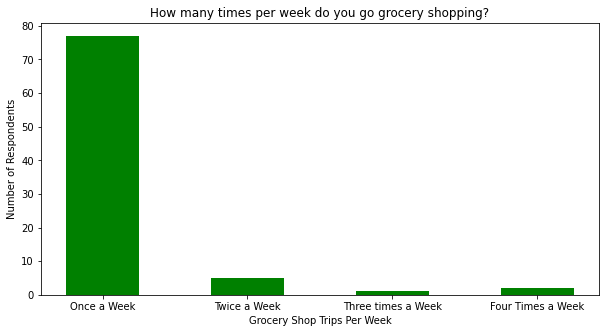

In [59]:
GroceryShopping_dict = {'Once a Week':77, 'Twice a Week':5, 'Three times a Week':1, 'Four Times a Week': 2}
frequency_of_shopping = list(GroceryShopping_dict.keys())
values = list(GroceryShopping_dict.values())
fig_GroceryShopping_Freq = plt.figure(figsize = (10, 5))

# Bar plot
plt.bar(frequency_of_shopping, values, color ='green',
        width = 0.5)
plt.xlabel("Grocery Shop Trips Per Week")
plt.ylabel("Number of Respondents")
plt.title("How many times per week do you go grocery shopping?")
plt.show()

In [60]:
df_survey['How much do you spend on an average grocery-shopping trip?'].value_counts()

$ 20 - 40     33
$ 40 - 60     25
$ 60 - 80     12
$ 80 - 100     7
$ 100 +        5
$ 0 - 20       3
               1
Name: How much do you spend on an average grocery-shopping trip?, dtype: int64

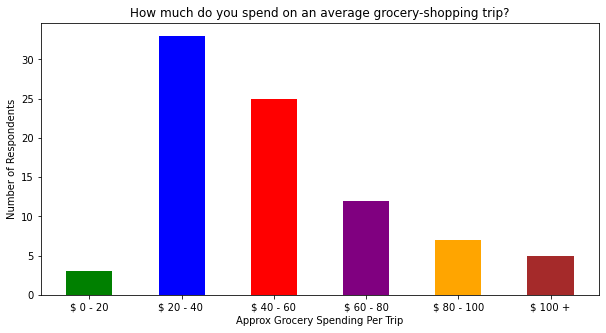

In [61]:
GrocerySpending_dict = {'$ 0 - 20':3, '$ 20 - 40 ':33, '$ 40 - 60':25, '$ 60 - 80':12, '$ 80 - 100':7, '$ 100 +':5}
spending_per_shopping = list(GrocerySpending_dict.keys())
values = list(GrocerySpending_dict.values())
fig_GrocerySpending_Per = plt.figure(figsize = (10, 5))

# Bar plot
plt.bar(spending_per_shopping, values, color = ['green','blue', 'red', 'purple', 'orange', 'brown']
        , width = 0.5)

plt.xlabel("Approx Grocery Spending Per Trip")
plt.ylabel("Number of Respondents")
plt.title("How much do you spend on an average grocery-shopping trip?")
plt.show()

In [62]:
df_survey['Where do you grocery shop the most in Berkeley?'].value_counts()

Trader Joe's     59
Safeway          14
Berkeley Bowl    11
Whole Foods       2
Name: Where do you grocery shop the most in Berkeley?, dtype: int64

In [63]:
tj_percent = (59/86)*100
safeway_percent = (14/86)*100
bb_percent= (11/86)*100
wf_percent = (2/86)*100

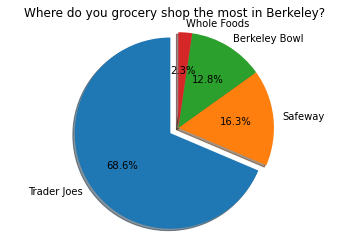

In [64]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Trader Joes', 'Safeway', 'Berkeley Bowl', 'Whole Foods'
sizes = [tj_percent, safeway_percent, bb_percent, wf_percent]
explode = (0.1, 0, 0, 0)  # only "explode" the 1st slice Trader Joes

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Where do you grocery shop the most in Berkeley?")
plt.show()

In [65]:
df_survey['What is your preferred diet?'].value_counts()

Omnivorous     66
Vegetarian     14
Vegan           3
Pescatarian     3
Name: What is your preferred diet?, dtype: int64

In [66]:
om_percent = (66/86)*100
veget_percent = (14/86)*100
vegan_percent= (3/86)*100
pesc_percent = (3/86)*100

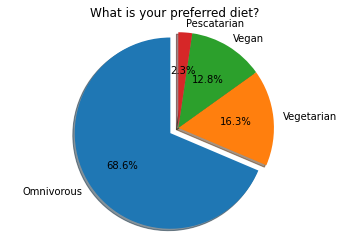

In [67]:
labels_diet = 'Omnivorous', 'Vegetarian', 'Vegan', 'Pescatarian'
sizes_diet = [om_percent, veget_percent, vegan_percent, pesc_percent]
explode_diet = (0.1, 0, 0, 0)  # only "explode" the 1st slice Trader Joes

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode_diet, labels=labels_diet, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("What is your preferred diet?")
plt.show()